# Homework 4 - Getting to know your customers

Over time, the Banking sector has dabbled into plenty of Data Science applications. The latter includes topics such as Fraud detection, risk modelling for investment, personalized marketing, managing customer data and customer segmentation, among others. The latter is a crucial topic for a bank since they can offer their products more accurately and tailor-made depending on their clients' characteristics and how probable they will consume more services from the bank.

Now, you and your team have been hired by a bank to get to know their customers. In other words, you will implement hashing and clustering techniques to extract relevant information and highlights from those clients and their transactions.

Then, let's get started!

In [111]:
import pandas as pd
from datetime import datetime
from random import randint
from tqdm import tqdm
import numpy as np
from numpy.linalg import norm
from operator import itemgetter
import pickle as pkl

In [112]:
data = pd.read_csv("bank_transactions.csv")   # importing the dataset

In [113]:
data                                          # visualize the data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


In [25]:
data.info()                                                 # showing some info on the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [26]:
data.isna().sum()                                     # counts of rows with na

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [28]:
data.dropna(inplace=True)                                # removing na

In [29]:
data.isna().sum()                                        # check

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [30]:
data.CustomerDOB =  pd.to_datetime(data.CustomerDOB)

In [31]:
data.TransactionDate  = pd.to_datetime(data.TransactionDate)

In [32]:
data.TransactionTime = data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

<AxesSubplot: >

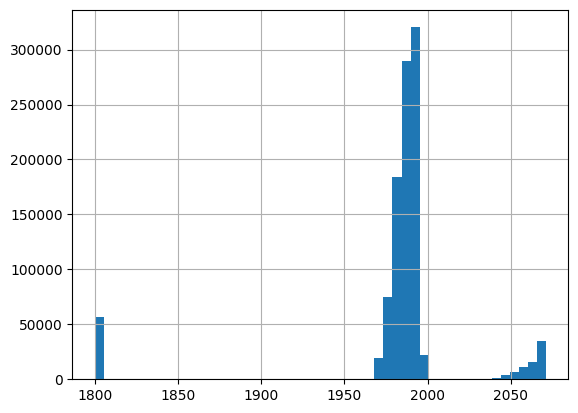

In [33]:
data.CustomerDOB.dt.year.hist(bins=50)

In [36]:
data.loc[data.CustomerDOB.dt.year > 2000,'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000,'CustomerDOB']  - pd.DateOffset(years=100)

In [37]:
data.drop(data.loc[data.CustomerDOB.dt.year==1800].index,axis=0,inplace=True)

<AxesSubplot: >

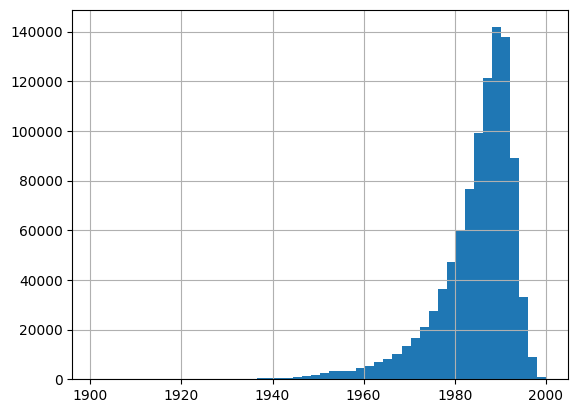

In [38]:
data.CustomerDOB.dt.year.hist(bins=50)

In [41]:
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)

In [42]:
data.TransactionDate = pd.to_datetime(data.TransactionDate)

In [43]:
data.CustGender = [str(x) for x in data.CustGender]

In [44]:
data.CustLocation = [str(x) for x in data.CustLocation]

In [48]:
data.to_pickle("processed.pkl")

## 1. Finding Similar Costumers

Companies nowadays are implementing product suggestions to provide users with things they are likely to buy. 

The process often starts by finding similar behaviours among consumers; for this task, we will focus on this part in the specific.

Here you will implement an algorithm to find the most similar match to a consumer given his bank account information. 

In particular, you will implement your version of the LSH algorithm that takes as input information about a consumer and finds people similar to the one in the study.

### 1.1 Set up the data

In [114]:
data = pd.read_pickle('processed.pkl')

In [50]:
newdata = data.drop(['CustomerID','TransactionID'], axis = 1)

In [51]:
newdata.index = [x for x in range(len(newdata))]

In [52]:
newdata.info

<bound method DataFrame.info of        CustomerDOB CustGender   CustLocation  CustAccountBalance  \
0       1994-10-01          F     JAMSHEDPUR            17819.05   
1       1957-04-04          M        JHAJJAR             2270.69   
2       1996-11-26          F         MUMBAI            17874.44   
3       1973-09-14          F         MUMBAI           866503.21   
4       1988-03-24          F    NAVI MUMBAI             6714.43   
...            ...        ...            ...                 ...   
985317  1990-08-04          M      NEW DELHI             7635.19   
985318  1992-02-20          M         NASHIK            27311.42   
985319  1989-05-18          M      HYDERABAD           221757.06   
985320  1978-08-30          M  VISAKHAPATNAM            10117.87   
985321  1984-05-03          M           PUNE            75734.42   

       TransactionDate     TransactionTime  TransactionAmount (INR)  
0           2016-02-08 1900-01-01 14:32:07                     25.0  
1          

In [53]:
newdata.to_pickle('newdata.pkl')

### 1.2 Fingerprint hashing

### HASH FUNCTIONS

In [54]:
def hash_date(value):
    return int(pd.Timestamp(value).timestamp())

In [55]:
def hash_string(value,p):
    m =2^32 -1
    return sum([ ord(x)*(p^i) for i,x in enumerate(value)])%m

In [56]:
def hash_float(value):
    integer,decimal  = str(value).split('.')
    return int(integer+decimal)

### MINHASH

In [57]:
def minHash(customer,p,permutations):
    vec  = [0 for i in range(len(customer)) ]
    for i,val in enumerate(customer):
        if not isinstance(val,int):
            if isinstance(val,datetime): 
                val  = hash_date(val)
            elif isinstance(val,str): 
                val = hash_string(val,p)
            elif isinstance(val,float): 
                val = hash_float(val)

        mini = float('inf')
        for perm_vals in permutations:
            a,b = perm_vals
            output = (a*val +b)%p

            if(mini > output):
                mini  = output

        vec[i] = output
    return vec
    

### MinHash applied to kaggle dataset

In [58]:
p  = 4993
max_val = 2^32-1
N  = 10
permutations = [ (randint(0,max_val),randint(0,max_val)) for i in range(N)]
newdata['minhash']  = [minHash([*x[1]],p,permutations) for x in tqdm(newdata.iterrows())]

985322it [01:20, 12179.89it/s]


### 1.3 Locality Sensitive Hashing

In [59]:
query_csv = pd.read_csv('query_users.csv')

In [60]:
query_csv.to_pickle('query.pkl')

### Read Query.csv

In [61]:
query  = pd.read_pickle('query.pkl')

### MinHash applied to query dataset

In [62]:
query['minhash']  = [minHash([*x[1]],p,permutations) for x in tqdm(query.iterrows())]

50it [00:00, 10003.59it/s]


### Check similarity

In [63]:
def cosine_sim(A,B):
    cosine = np.dot(A,B)/(norm(A)*norm(B))
    return cosine

In [64]:
def find_best_neighbour(query):
    norm_q_hash  = np.array(query.minhash)/max(query.minhash)
    best_score = max([(cosine_sim(norm_q_hash,(np.array(x)/max(x))),i) for i,x in enumerate(newdata.minhash)],key=itemgetter(0))
    return best_score


In [16]:
neighbours = []
for i in range(len(query)):
    if i in query.index:
        res = find_best_neighbour(query.loc[i])
        neighbours.append(res[1])

#### Query dataset

In [18]:
display(query)


,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),minhash
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.00,"[225, 73, 41, 2701, 169, 4057, 216]"
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.00,"[17, 73, 25, 786, 169, 3065, 2681]"
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.50,"[113, 73, 89, 262, 145, 1350, 3385]"
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.00,"[97, 73, 33, 1965, 9, 4723, 121]"
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.00,"[81, 73, 9, 390, 161, 4092, 1416]"
5,10/1/81,M,WORLD TRADE CENTRE BANGALORE,23143.95,11/9/16,192906,303.00,"[49, 73, 49, 1125, 225, 420, 4277]"
6,20/9/76,F,CHITTOOR,15397.80,28/8/16,92633,20.00,"[153, 25, 145, 3555, 209, 2109, 1609]"
7,10/4/91,M,MOHALI,426.30,2/8/16,203754,50.00,"[25, 73, 177, 4155, 113, 2323, 4009]"
8,19/3/90,M,MOHALI,4609.34,26/8/16,184015,300.00,"[177, 73, 177, 2647, 145, 4187, 4037]"
9,19/12/70,M,SERAMPORE,6695988.46,27/8/16,144030,299.00,"[169, 73, 57, 797, 177, 3859, 3957]"


#### Best neighbours in the kaggle datset based on the cosine similarity of  minhash  vector

In [140]:
newdata = pd.read_pickle("newdata.pkl")

In [19]:
display(newdata.loc[neighbours])

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),minhash
467195,1990-09-21,M,NOIDA,10201.66,2016-08-20,160920,1066.00,"[278, 73, 57, 2775, 210, 4168, 408]"
351868,1987-07-24,M,GHAZIABAD,24104.64,2016-08-13,144537,966.00,"[41, 73, 9, 755, 27, 2922, 2394]"
470885,1990-07-23,M,CHANDIGARH,4805.97,2016-08-20,190505,100.00,"[136, 73, 113, 175, 210, 1184, 3016]"
357751,1985-02-05,M,MANGALORE,11186.45,2016-08-13,164041,500.00,"[77, 73, 25, 1713, 27, 4171, 65]"
467471,1989-01-25,M,BENGALURU,46023.34,2016-08-20,192010,1200.00,"[180, 73, 49, 299, 210, 3238, 1142]"
473439,1994-09-26,F,SOLAPUR,141503.14,2016-08-20,234715,620.00,"[86, 25, 97, 1225, 210, 361, 4672]"
555226,1988-08-19,F,HALL WHITEFIELD BANGALORE,1285360.13,2016-08-27,215041,1774.50,"[303, 25, 161, 4728, 393, 2745, 2165]"
356073,1972-09-09,F,MUMBAI,1497.17,2016-08-13,163812,990.00,"[3, 25, 137, 4418, 27, 2339, 4314]"
464958,1987-05-09,F,INDORE,53403.14,2016-08-20,195228,366.83,"[194, 25, 145, 2413, 210, 4017, 3879]"
475782,1987-12-07,M,BAGALKOT,88.45,2016-08-20,215259,747.00,"[30, 73, 41, 867, 210, 4489, 4846]"


## 2. Grouping customers together!

Now we will deal with clustering algorithms that will provide groups of clients which are similar among them.

### 2.1 Getting your data + feature engineering

2.1 Access to the data found in this dataset (it is the same dataset from the previous question 1.1).

In [274]:
newdata = pd.read_pickle("processed.pkl")

In [275]:
newdata.index = [x for x in range(len(newdata))]

2.2 Sometimes, the features (variables, fields) are not given in a dataset but can be created from it. The previous step is known as feature engineering. For example, the original dataset has several transactions done by the same customer. Then, we suggest you to group data by the client (using CustomerId) and, based on it, create the following new features for each CustomerId:

####   a) Number of transactions

In [276]:
newdata["NumberTransactions"] = newdata.groupby('CustomerID')["TransactionID"].transform("count")

#### b) Number of transactions with a balance bigger than 100 UDS   da fare

In [278]:
newdata["TransactionAmount (USD)"] = newdata["TransactionAmount (INR)"] * 0.012244201

In [176]:
newdata["TransactionAmountusd"] = newdata["TransactionAmount (USD)"]

In [184]:
newdata[newdata.TransactionAmountusd > 100]["TransactionAmountusd"].count()

AttributeError: 'SeriesGroupBy' object has no attribute 'newdata'

In [177]:
newdata.groupby('CustomerID').[TransactionAmountusd.count()

CustomerID
C1010011    2
C1010012    1
C1010014    2
C1010018    1
C1010024    1
           ..
C9099836    1
C9099877    1
C9099919    1
C9099941    1
C9099956    1
Name: TransactionAmountusd, Length: 839081, dtype: int64

In [161]:
newdata["NTrans_>100"] = newdata.groupby('CustomerID').TransactionAmountusd.count()

SyntaxError: invalid syntax (3510126176.py, line 1)

In [166]:
column = newdata["TransactionAmount (USD)"]

In [175]:
newdata.groupby('CustomerID')["TransactionAmount (USD)"].count()

CustomerID
C1010011    2
C1010012    1
C1010014    2
C1010018    1
C1010024    1
           ..
C9099836    1
C9099877    1
C9099919    1
C9099941    1
C9099956    1
Name: TransactionAmount (USD), Length: 839081, dtype: int64

In [ ]:
c = Counter()


In [ ]:
newdata.CustomerID[271]

'C5122418'

In [ ]:
newdata["TransactionAmount (USD)"].values

array([3.06105025e-01, 3.42825384e+02, 5.62008826e+00, ...,
       9.42803477e+00, 1.22442010e+01, 1.42767384e+01])

In [ ]:
for i in range(len(newdata.CustomerID)):
    if newdata["TransactionAmount (USD)"].iloc[i] > 100:
        c[newdata.CustomerID[i]] += 1

In [131]:
lista2 = []
for i in newdata.CustomerID:
    lista2.append(c[i])
    

In [132]:
newdata["NTrans_>100"] = lista2

In [136]:
newdata

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumberTransactions,TransactionAmount (USD),NTrans_>100
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,0.306105,0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,342.825384,1
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,5.620088,0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0,2,25.223054,0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5,1,21.580404,0
...,...,...,...,...,...,...,...,...,...,...,...,...
985317,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,1,9.783117,0
985318,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,1,5.632332,0
985319,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,2,9.428035,0
985320,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,1,12.244201,0


#### c) Average amount of transactions

In [187]:
newdata["AverageAmount (INR)"] = newdata.groupby('CustomerID')["TransactionAmount (INR)"].transform("mean")

#### d) Average Balance

In [190]:
newdata["AverageBalance (INR)"] = newdata.groupby('CustomerID')["CustAccountBalance"].transform("mean")

#### e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as    utilisation).

In [198]:
newdata["Utilization"] = newdata["AverageBalance (INR)"] - newdata["AverageAmount (INR)"]

In [199]:
newdata

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumberTransactions,NumberTransactions2,TransactionAmount (USD),TransactionAmountusd,AverageAmount (INR),AverageAmount (USD),AverageBalance (INR),Utilization
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,1,0.306105,0.306105,25.0,0.306105,17819.050,17794.050
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,1,342.825384,342.825384,27999.0,342.825384,2270.690,-25728.310
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,1,5.620088,5.620088,459.0,5.620088,17874.440,17415.440
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0,2,2,25.223054,25.223054,1469.2,17.989180,434849.495,433380.295
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5,1,1,21.580404,21.580404,1762.5,21.580404,6714.430,4951.930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985317,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,1,1,9.783117,9.783117,799.0,9.783117,7635.190,6836.190
985318,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,1,1,5.632332,5.632332,460.0,5.632332,27311.420,26851.420
985319,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,2,2,9.428035,9.428035,489.0,5.987414,112719.330,112230.330
985320,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,1,1,12.244201,12.244201,1000.0,12.244201,10117.870,9117.870


#### f) Most common gender of the customer

In [214]:
newdata.groupby(['CustomerID',"CustGender"])["CustGender"].count().sort_values(by = "CustGender" )

TypeError: Series.sort_values() got an unexpected keyword argument 'by'

In [215]:
pd.dataframe[data = newdata newdata.groupby(['CustomerID',"CustGender"])["CustGender"].count()]

CustomerID  CustGender
C1010011    F             1
            M             1
C1010012    M             1
C1010014    F             1
            M             1
                         ..
C9099836    M             1
C9099877    M             1
C9099919    M             1
C9099941    M             1
C9099956    M             1
Name: CustGender, Length: 893782, dtype: int64

In [251]:
result = newdata.groupby(['CustomerID'])['CustGender'].agg(pd.Series.mode).transform(lambda x: x)

In [259]:
result = newdata.groupby(['CustomerID'])['CustGender'].agg(pd.Series.mode).transform((pd.Series.mode))

KeyboardInterrupt: 

In [254]:
result

0    M
Name: CustGender, dtype: object

In [246]:
len(result.CustGender)

839081

In [241]:
newdata["MostCommonGender"] = result["CustGender"]

In [242]:
newdata

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumberTransactions,NumberTransactions2,TransactionAmount (USD),TransactionAmountusd,AverageAmount (INR),AverageAmount (USD),AverageBalance (INR),Utilization,MostCommonGender
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,1,0.306105,0.306105,25.0,0.306105,17819.050,17794.050,NaN
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,1,342.825384,342.825384,27999.0,342.825384,2270.690,-25728.310,NaN
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,1,5.620088,5.620088,459.0,5.620088,17874.440,17415.440,NaN
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0,2,2,25.223054,25.223054,1469.2,17.989180,434849.495,433380.295,NaN
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5,1,1,21.580404,21.580404,1762.5,21.580404,6714.430,4951.930,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985317,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,1,1,9.783117,9.783117,799.0,9.783117,7635.190,6836.190,NaN
985318,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,1,1,5.632332,5.632332,460.0,5.632332,27311.420,26851.420,NaN
985319,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,2,2,9.428035,9.428035,489.0,5.987414,112719.330,112230.330,NaN
985320,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,1,1,12.244201,12.244201,1000.0,12.244201,10117.870,9117.870,NaN


#### g) Most frequent location of the customer

2.3 Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. Moreover, add it to the previous dataset (the one with seven features).

#### AverageAmount (USD)

In [189]:
newdata["AverageAmount (USD)"] = newdata.groupby('CustomerID')["TransactionAmount (USD)"].transform("mean")  

#### CustAccountBalance (USD)

In [268]:
newdata["CustAccountBalance (USD)"] = newdata["CustAccountBalance"] * 0.012244201

#### AverageBalance (USD)

In [261]:
newdata["AverageBalance (USD)"] = newdata["AverageBalance (INR)"] * 0.012244201

#### MaxAmountTrans (USD)

In [265]:
newdata["MaxAmountTrans (USD)"] = newdata.groupby('CustomerID')["TransactionAmount (USD)"].transform("max")  

#### MinAmountTrans (USD)

In [266]:
newdata["MinAmountTrans (USD)"] = newdata.groupby('CustomerID')["TransactionAmount (USD)"].transform("min") 

#### MaxBalance (USD)

In [270]:
newdata["MaxBalance (USD)"] = newdata.groupby('CustomerID')["CustAccountBalance (USD)"].transform("max") 

#### MinBalance (USD)

In [272]:
newdata["MinBalance (USD)"] = newdata.groupby('CustomerID')["CustAccountBalance (USD)"].transform("min") 

In [273]:
newdata

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),NumberTransactions,...,AverageAmount (USD),AverageBalance (INR),Utilization,MostCommonGender,CustAccountBalance (USD),AverageBalance (USD),MaxAmountTrans (USD),MinAmountTrans (USD),MaxBalance (USD),MinBalance (USD)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,1,...,0.306105,17819.050,17794.050,NaN,218.180030,218.180030,0.306105,0.306105,218.180030,218.180030
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,1900-01-01 14:18:58,27999.0,1,...,342.825384,2270.690,-25728.310,NaN,27.802785,27.802785,342.825384,342.825384,27.802785,27.802785
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,1,...,5.620088,17874.440,17415.440,NaN,218.858236,218.858236,5.620088,5.620088,218.858236,218.858236
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,1900-01-01 14:27:14,2060.0,2,...,17.989180,434849.495,433380.295,NaN,10609.639470,5324.384622,25.223054,10.755306,10609.639470,39.129773
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5,1,...,21.580404,6714.430,4951.930,NaN,82.212831,82.212831,21.580404,21.580404,82.212831,82.212831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985317,T1048563,C8020229,1990-08-04,M,NEW DELHI,7635.19,2016-09-18,1900-01-01 18:48:24,799.0,1,...,9.783117,7635.190,6836.190,NaN,93.486801,93.486801,9.783117,9.783117,93.486801,93.486801
985318,T1048564,C6459278,1992-02-20,M,NASHIK,27311.42,2016-09-18,1900-01-01 18:37:34,460.0,1,...,5.632332,27311.420,26851.420,NaN,334.406516,334.406516,5.632332,5.632332,334.406516,334.406516
985319,T1048565,C6412354,1989-05-18,M,HYDERABAD,221757.06,2016-09-18,1900-01-01 18:33:13,770.0,2,...,5.987414,112719.330,112230.330,NaN,2715.238016,1380.158133,9.428035,2.546794,2715.238016,45.078250
985320,T1048566,C6420483,1978-08-30,M,VISAKHAPATNAM,10117.87,2016-09-18,1900-01-01 18:47:06,1000.0,1,...,12.244201,10117.870,9117.870,NaN,123.885234,123.885234,12.244201,12.244201,123.885234,123.885234


### 2.2 Choose your features (variables)!

### 2.3 Clustering!

### 2.4 Analysing your results!

## Bonus

Think about any two other clustering algorithms that you would like to use for the dataset (of course, you can use implemented version of them, e.g. from the scikit-learn library). Compare the results of chosen two algorithms with K-means implemented by you and K-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

## Algorithmic Question

In [ ]:
entry,n_studs,n_guards= list(map(int,input().split()))

students  = list(map(int,input().split()))

guards = 1
for i in range(1,n_studs) :
    if(students[i] != students[i-1] and students[i] not in students[:i]):
        if(students[i-1] in students[i:]):
            guards += 1

print( 'Yes' if guards <= n_guards else 'No')

No
